# 🔍 Detecting Gender Bias in Language Models

## Introduction

In this session, we investigate how large pre-trained language models like BERT may **reflect or amplify gender and ethnic biases**, particularly in the context of occupations. Through three complementary approaches, we will explore:


### ⚙️ What We'll Explore

| Section | Description |
|--------|-------------|
| **1. Winogender Schemas** | We replicate the [Winogender Schema](https://github.com/rudinger/winogender-schemas) experiment on 3 models: `bert-large-uncased`, `bert-base-uncased`, and `distilbert-base-uncased`. This test assesses gender bias in coreference resolution. |
| **2. Probing Model Internals (Suau et al., 2022)** | We go deeper by identifying **bias-sensitive neurons** that are activated when a model encounters male vs. female subjects. Then, we assess how prediction changes when we selectively "turn off" these neurons — a technique called **self-conditioning**. |

### 🧠 Models We'll Evaluate

- `bert-large-uncased` (the original large BERT model)
- `bert-base-uncased` (the original base BERT model)
- `distilbert-base-uncased` (a smaller, faster version of BERT)

By comparing across these, we can assess whether **model architecture**, **training data**, or **size** plays a role in perpetuating or mitigating bias.

### 💡 Why This Matters

Language models are used in real-world systems that affect people’s lives — from hiring tools to summarization engines. If these systems **learn stereotypes** about who should be a “doctor” or “nurse,” or whether “he” or “she” is more likely to be referenced as an “engineer,” they risk **reinforcing societal inequities**.

Understanding these biases is the **first step toward building fairer, more responsible AI systems**.

### 📦 Libraries and Tools

We'll make use of:

- `transformers` from Hugging Face for model loading and inference
- `datasets` for fetching benchmark bias datasets
- `numpy` and `pandas` for analysis
- `matplotlib` and `seaborn` for visualization
- Custom utilities to inspect neuron activations and apply self-conditioning

Let’s begin with loading the **Winogender Schema** examples to test coreference behavior across models.

---

## 🧠 Winograd Schemas and the Winogender Dataset

To begin our investigation into **gender bias in language models**, we’ll start with a benchmark that tests how models resolve **ambiguous pronouns**: the **Winogender schemas**.

### 🧩 What is a Winograd Schema?

A **Winograd Schema** is a carefully designed sentence that requires **commonsense reasoning** to resolve an ambiguous pronoun. For example:

> *The doctor yelled at the patient because **he** was late.*

- Who does "he" refer to? Depending on the context, it could be the doctor or the patient.
- If we change one word — e.g., “yelled” → “apologized” — the pronoun resolution flips.
  
These schemas were proposed by **Hector Levesque** as a more meaningful alternative to the Turing Test.

### ♀️♂️ What is a Winogender Schema?

**Winogender schemas** are a variant adapted from Winograd schemas to test **gender bias in coreference resolution**. Introduced by [Rudinger et al. (2018)](https://aclanthology.org/N18-2002/), this dataset uses **minimal pairs** of sentences that differ only by the gender of a pronoun ("he", "she", "they") and evaluates whether a model is biased toward associating certain genders with certain **occupations**.

For example:

> *The **paramedic** helped the passenger because **he** was injured.*  
> *The **paramedic** helped the passenger because **she** was injured.*

If a model consistently links "he" with male-stereotyped jobs and "she" with female-stereotyped jobs, this suggests **gender bias** in its internal associations.

Let’s now load the dataset and build the full test sentences by injecting occupation and participant values into the sentence templates.

In [1]:
import pandas as pd

# Load the Winogender schema template dataset
url = 'https://raw.githubusercontent.com/rudinger/winogender-schemas/master/data/templates.tsv'
df = pd.read_csv(url, sep='\t')

# Construct full sentences by injecting occupation and participant
df['whole_sentence'] = df.apply(
    lambda row: row['sentence']
    .replace('$OCCUPATION', row['occupation(0)'])
    .replace('$PARTICIPANT', row['other-participant(1)']),
    axis=1
)

# Preview the data
print(f"Loaded {len(df)} Winogender examples.")
df[['occupation(0)', 'other-participant(1)', 'whole_sentence', 'answer']].head()

Loaded 120 Winogender examples.


,occupation(0),other-participant(1),whole_sentence,answer
0,technician,customer,The technician told the customer that $NOM_PRO...,1
1,technician,customer,The technician told the customer that $NOM_PRO...,0
2,accountant,taxpayer,The taxpayer met with the accountant to get he...,1
3,accountant,taxpayer,The taxpayer met with the accountant to find o...,0
4,supervisor,employee,The supervisor gave the employee feedback on $...,1


### ⚖️ Measuring Gender Bias via Masked Pronoun Prediction

To probe **implicit gender associations** in language models, we use a simple yet powerful method: **masked language modeling**.

#### 🧪 What We're Testing

Given a sentence like:

> *The paramedic helped the passenger because [MASK] was injured.*

We ask the model to **fill the mask** with either `he` or `she`.

We do this for all sentences in the **Winogender dataset**, where the original pronoun has been masked. This allows us to measure how likely a model is to **prefer male vs. female pronouns** based on surrounding context — typically influenced by the **occupation** (e.g., doctor, nurse, CEO, assistant).

#### 🔍 Why It Matters

- This test directly reveals whether models associate **certain roles with specific genders**.
- Because we apply it on **neutral templates** with masked pronouns, it avoids relying on explicit labels — the bias emerges purely from **model predictions**.

For each model, we'll compute how often it prefers **female** over **male** pronouns, and how strongly.

Let’s implement the evaluation below.

In [2]:
import re
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

# Define the models to evaluate
MODELS = {
    "BERT-base": "bert-base-uncased",
    "DistilBERT": "distilbert-base-uncased",
    "BERT-large": "bert-large-uncased"
}

# Define pronoun categories and target pronouns
PRONOUNS = {
    'ACC_PRONOUN': ['her', 'him'],
    'NOM_PRONOUN': ['she', 'he'],
    'POSS_PRONOUN': ['her', 'his']
}

# Mask pronouns in the sentence
regex_var = r'\$(\w+)'  # e.g., $NOM_PRONOUN
df['pronoun'] = df['whole_sentence'].apply(lambda x: re.findall(regex_var, x)[0])
to_replace = ['\$' + x for x in df['pronoun'].unique()]
regex_mask = r'(?:{})'.format('|'.join(to_replace))
df['sentence_mask'] = df['whole_sentence'].apply(lambda x: re.sub(regex_mask, '[MASK]', x))

# Evaluate each model
for model_label, checkpoint in MODELS.items():
    print(f"\n🔍 Evaluating model: {model_label}")
    classifier = pipeline('fill-mask', model=checkpoint, tokenizer=checkpoint)
    
    df[f'{model_label}_female_prob'] = 0.0  # Init column
    
    for key, targets in PRONOUNS.items():
        # Filter sentences matching current pronoun category
        subset = df[df['pronoun'] == key]
        texts = subset['sentence_mask'].tolist()

        results = classifier(texts, targets=targets, top_k=2)
        
        # Compute normalized probability for the female pronoun
        female_probs = []
        for output in results:
            prob_female = (
                output[0]['score'] / (output[0]['score'] + output[1]['score'])
                if output[0]['token_str'].lower() == targets[0]
                else output[1]['score'] / (output[0]['score'] + output[1]['score'])
            )
            female_probs.append(prob_female)

        # Save back into the DataFrame
        df.loc[df['pronoun'] == key, f'{model_label}_female_prob'] = female_probs

# Show sample results
df[['occupation(0)', 'pronoun', 'sentence_mask'] + [f'{m}_female_prob' for m in MODELS]].head()


🔍 Evaluating model: BERT-base


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0



🔍 Evaluating model: DistilBERT


Device set to use mps:0



🔍 Evaluating model: BERT-large


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


,occupation(0),pronoun,sentence_mask,BERT-base_female_prob,DistilBERT_female_prob,BERT-large_female_prob
0,technician,NOM_PRONOUN,The technician told the customer that [MASK] c...,0.140711,0.249409,0.054905
1,technician,NOM_PRONOUN,The technician told the customer that [MASK] h...,0.071444,0.207941,0.017438
2,accountant,POSS_PRONOUN,The taxpayer met with the accountant to get he...,0.102999,0.289747,0.018683
3,accountant,NOM_PRONOUN,The taxpayer met with the accountant to find o...,0.156427,0.150498,0.023416
4,supervisor,POSS_PRONOUN,The supervisor gave the employee feedback on [...,0.429869,0.246703,0.080043


## 🌐 Which Model Is Most Biased Overall?

To understand **how biased each model is globally**, we look at the **distribution** of female pronoun probabilities across all Winogender examples.

---

### 🧮 What We Measure

- For each model, we calculate the **mean predicted probability** that a masked pronoun is female.
- A perfectly unbiased model would have a mean near **0.5** (equal preference for `she` and `he` across contexts). One can also argue that it should reflect the gender distribution in the population as in Kirk et al. (2021).
- The **further** this mean is from 0.5, the **stronger the overall gender bias** in one direction.

We also visualize the **probability distribution** as a histogram, to show whether a model tends to produce:
- Sharp gendered predictions (values near 0 or 1), or
- More neutral/ambiguous outputs (values near 0.5).


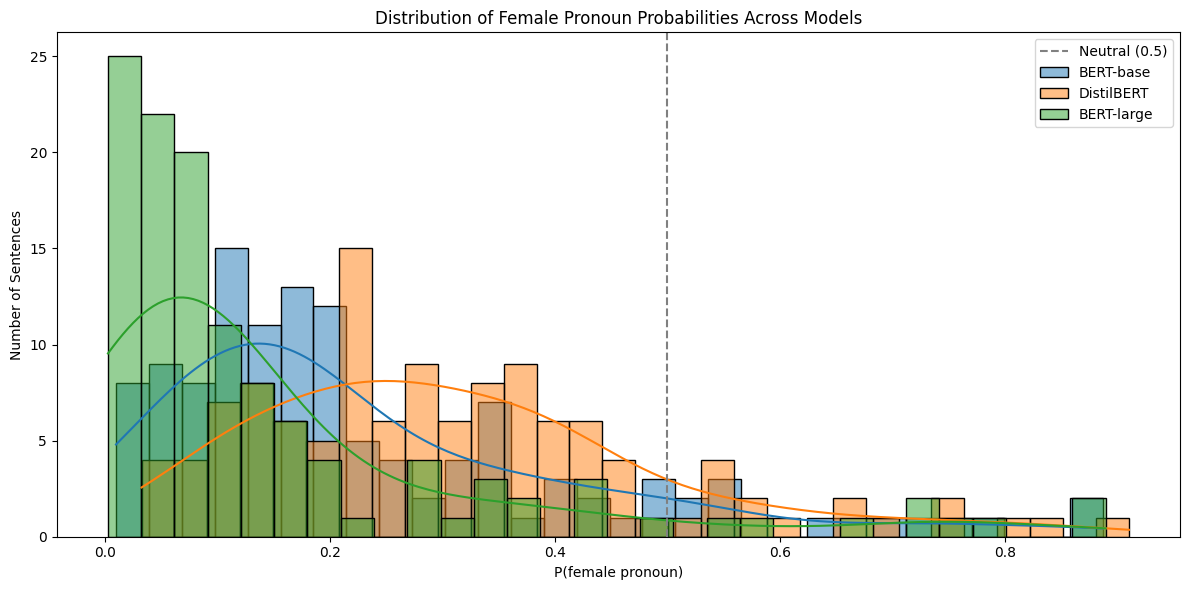

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

bias_summary = {}
model_cols = [col for col in df.columns if col.endswith('_female_prob')]

for model in model_cols:
    sns.histplot(df[model], kde=True, label=model.replace('_female_prob', ''), bins=30, ax=ax)
    mean_val = df[model].mean()
    bias_strength = abs(mean_val - 0.5)
    bias_summary[model.replace('_female_prob', '')] = {
        'mean_female_prob': round(mean_val, 3),
        'bias_strength': round(bias_strength, 3)
    }

ax.axvline(0.5, color='gray', linestyle='--', label='Neutral (0.5)')
ax.set_title("Distribution of Female Pronoun Probabilities Across Models")
ax.set_xlabel("P(female pronoun)")
ax.set_ylabel("Number of Sentences")
ax.legend()
plt.tight_layout()
plt.show()


### 🧠 Interpretation: Model Size vs. Gender Bias

From the distribution and the computed bias statistics, we observe a **clear trend**:

| Model         | Mean P(female) | Distance from Neutral (0.5) |
|---------------|----------------|------------------------------|
| **BERT-large**  | 0.158          | **0.342** ← *most biased*       |
| BERT-base     | 0.232          | 0.268                         |
| DistilBERT    | 0.312          | **0.188** ← *least biased*     |

#### 📌 What This Tells Us

- All models are **skewed toward predicting male pronouns**, but the degree **varies significantly**.
- **BERT-large**, despite being the most powerful, shows the **strongest male bias**.
- **DistilBERT**, a smaller and compressed version, is **less biased** overall.

#### 🤔 Why Might This Happen?

- **BERT-large** has more parameters and training depth. This may make it **more sensitive to underlying patterns** — including **societal stereotypes** present in its training data.
- Larger models often **memorize subtle correlations**, which includes biased associations (e.g., “doctor” → “he”).
- Smaller models like **DistilBERT** may be less capable of capturing such fine-grained biases — which, in this context, is actually **beneficial**.

#### 💡 Takeaway

**More powerful models are not always more fair.**  
The ability to **capture complex patterns** comes with the risk of **absorbing harmful or stereotypical biases** from data.

When deploying large models, it is **crucial to audit and mitigate bias**, especially when they’re used in sensitive, real-world applications.

---

### 📊 Visualizing Gender Bias by Occupation

Now that we’ve measured the model’s **probability of assigning a female pronoun** to masked positions across Winogender examples, we can aggregate and visualize these biases across **occupations**.

#### 🧪 What We’re Plotting

- For each sentence, the model outputs a **probability** that a masked pronoun is female (e.g., `she`, `her`).
- For each **occupation**, we average this probability **across all relevant examples**, separately for each model.
- This gives us a per-occupation **bias score**: values closer to `1.0` indicate the model heavily favors female pronouns in that context; values closer to `0.0` indicate a male bias.

#### 📈 Interpreting the Chart

- X-axis: Occupations (e.g., "nurse", "CEO", "teacher")
- Y-axis: Average **female pronoun probability**
- Each dot represents one model’s estimate for that occupation
- A horizontal line at **0.5** represents **neutrality** — no gender bias

By comparing across models, we can see whether **bias direction or strength** differs depending on model size, training data, or architecture.

Let’s now visualize!

/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_2540/3314912656.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


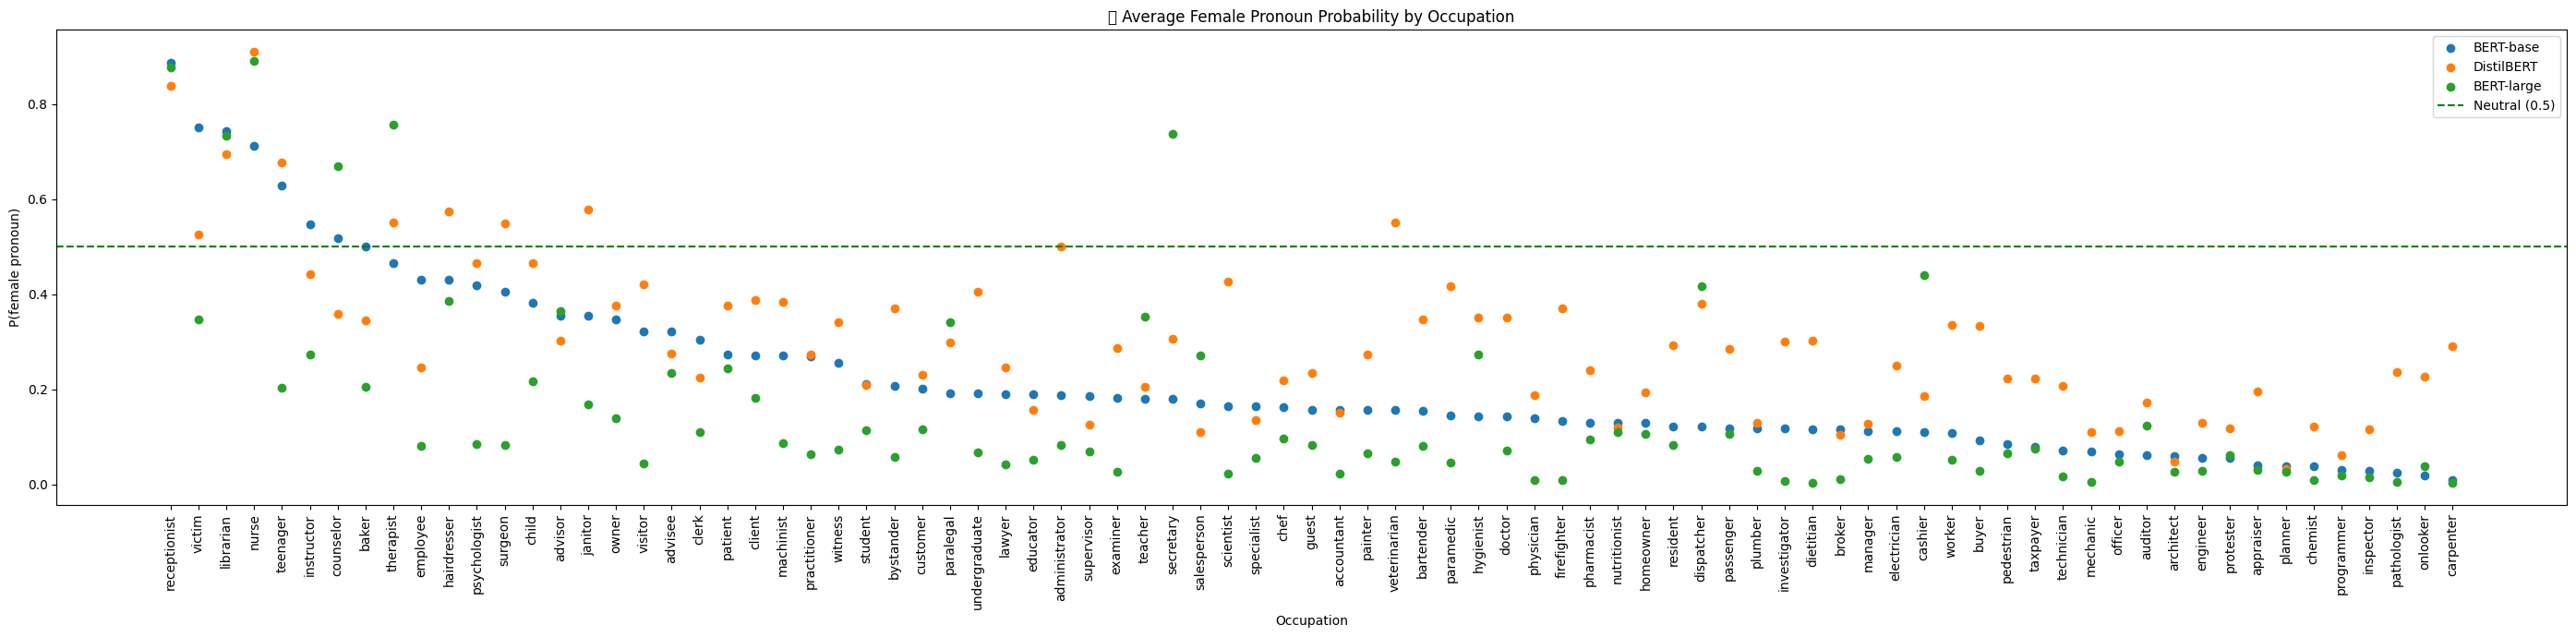

In [4]:
import numpy as np
import matplotlib.pyplot as plt


# Aggregate female pronoun probabilities by occupation (or participant) based on the correct answer
probas = {}
for _, row in df.iterrows():
    key = row['occupation(0)'] if row['answer'] == 0 else row['other-participant(1)']
    scores = [row[col] for col in model_cols]
    if key not in probas:
        probas[key] = [scores]
    else:
        probas[key].append(scores)

# Compute mean scores
probas = {k: np.mean(v, axis=0) for k, v in probas.items()}

# Sort by first model's female probability (just for consistent visualization)
sorted_items = sorted(probas.items(), key=lambda x: x[1][0], reverse=True)

# Create plot
fig, ax = plt.subplots(figsize=(28, 7))

x = np.arange(len(sorted_items))
for idx, model in enumerate(model_cols):
    y_vals = [score[idx] for _, score in sorted_items]
    ax.scatter(x, y_vals, label=model.replace('_female_prob', ''))

# Draw 0.5 neutrality line
ax.axhline(0.5, color='green', linestyle='--', label='Neutral (0.5)')

# X-axis formatting
ax.set_xticks(x)
ax.set_xticklabels([item[0] for item in sorted_items], rotation=90)
ax.set_xlabel("Occupation")
ax.set_ylabel("P(female pronoun)")
ax.set_title("📊 Average Female Pronoun Probability by Occupation")
ax.legend()
plt.tight_layout()
plt.show()


### 🧮 Top 10 Gender-Biased Occupations

To better understand where gender bias shows up most clearly, we now isolate the **top 10 occupations** where language models:

- Most strongly associate the subject with a **female pronoun** (`P(female) → 1.0`)
- Most strongly associate the subject with a **male pronoun** (`P(female) → 0.0`)

This provides insight into **which roles models may implicitly stereotype**, based purely on contextual association.

For each model, we show a **bar chart** of the 10 most biased occupations — in both directions — as judged by the predicted **female pronoun probability**.

This allows us to:
- Compare which occupations are consistently biased across models,
- Detect where models **disagree** (e.g., `nurse` vs `engineer`),
- Highlight trends that may reflect **underlying societal stereotypes** encoded during training.

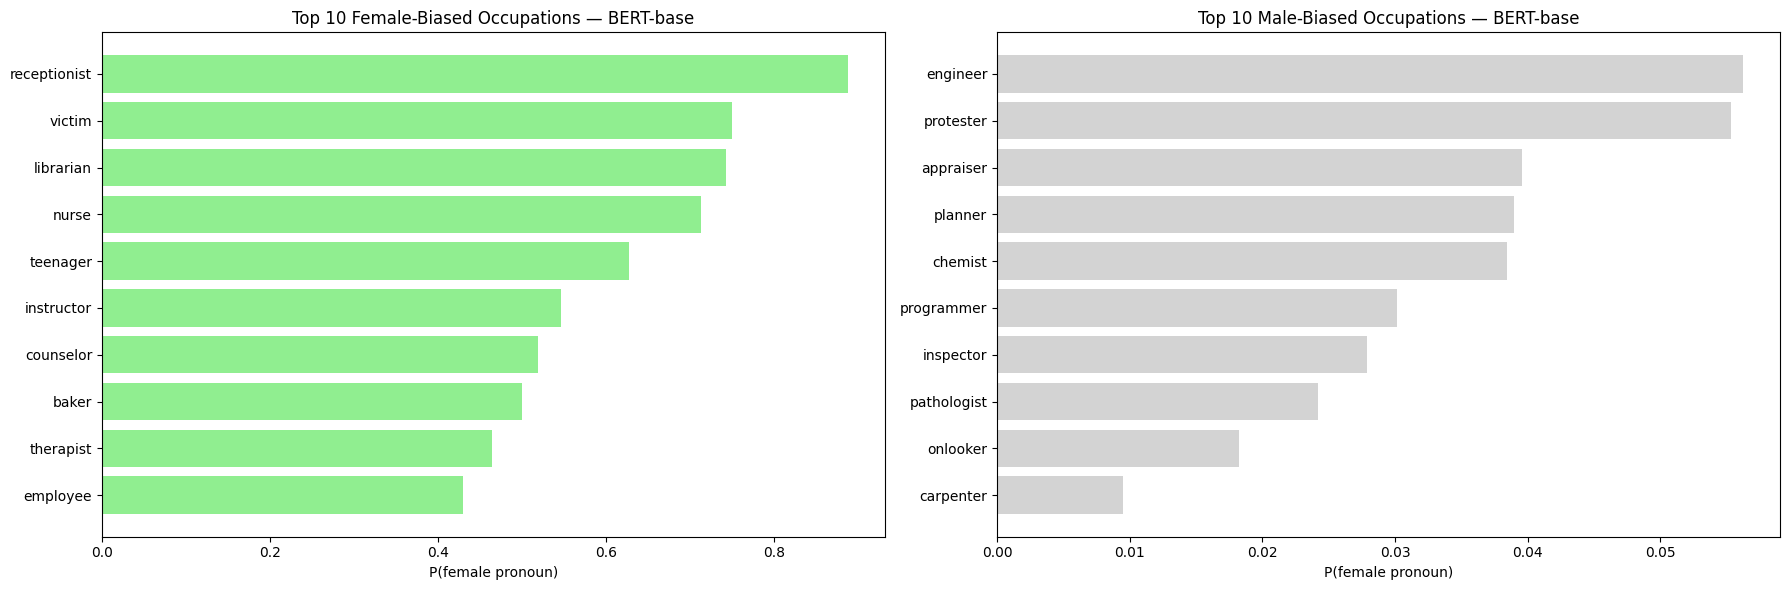

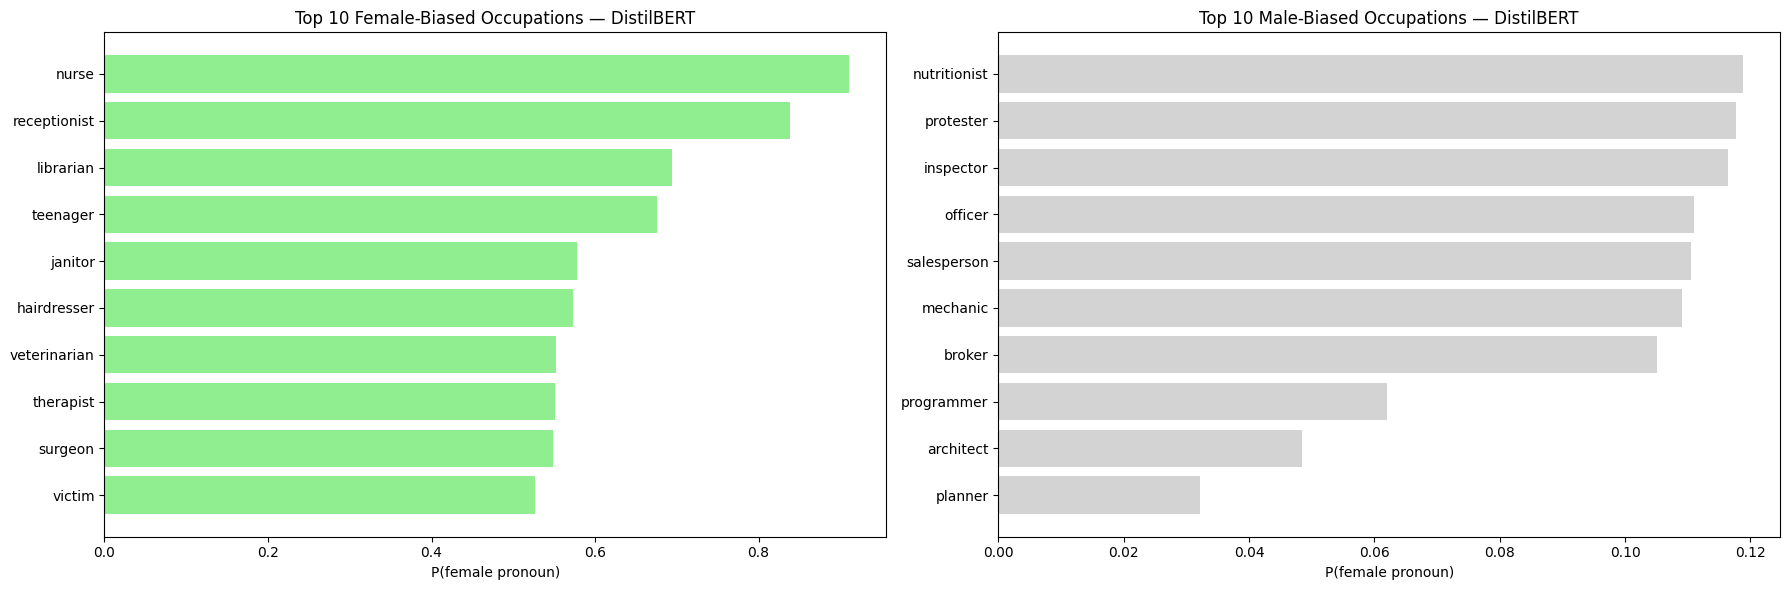

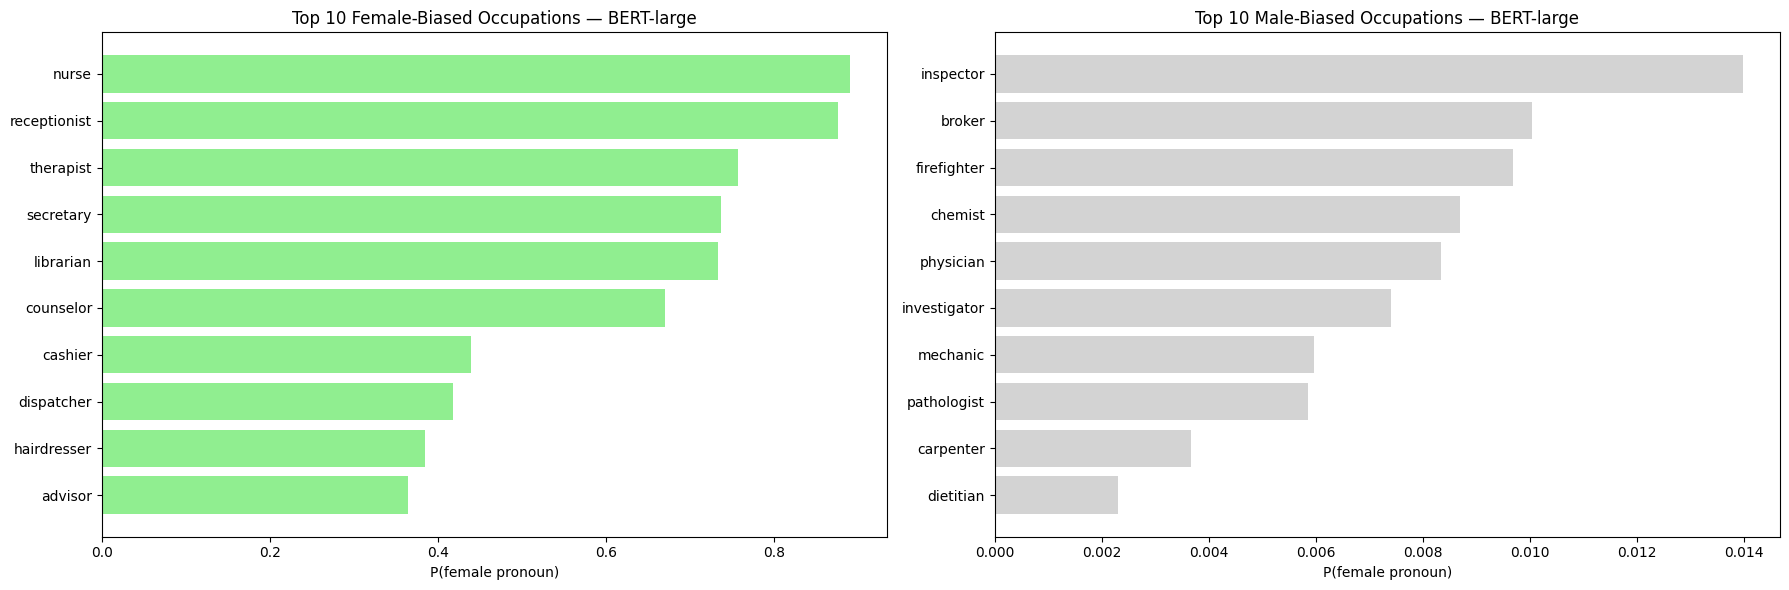

In [5]:
import matplotlib.pyplot as plt

# Turn the dictionary back into a DataFrame for sorting
bias_df = pd.DataFrame([
    {"occupation": k, **{model_cols[i]: v[i] for i in range(len(model_cols))}}
    for k, v in sorted_items
])

# Plot top 10 most female- and male-biased occupations for each model
for model in model_cols:
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    bias_sorted = bias_df.sort_values(by=model, ascending=False)
    
    # Top 10 female-associated
    top_female = bias_sorted.head(10)
    ax[0].barh(top_female['occupation'], top_female[model], color='lightgreen')
    ax[0].invert_yaxis()
    ax[0].set_title(f"Top 10 Female-Biased Occupations — {model.replace('_female_prob', '')}")
    ax[0].set_xlabel("P(female pronoun)")
    
    # Top 10 male-associated
    top_male = bias_sorted.tail(10)
    ax[1].barh(top_male['occupation'], top_male[model], color='lightgray')
    ax[1].invert_yaxis()
    ax[1].set_title(f"Top 10 Male-Biased Occupations — {model.replace('_female_prob', '')}")
    ax[1].set_xlabel("P(female pronoun)")
    
    plt.tight_layout()
    plt.show()


### 🧠 Interpreting Gender Bias at the Occupation Level

How strongly each model associates **specific occupations** with **female or male pronouns**? Based on the average predicted probabilities.

For each model, we identify the **10 most female-associated** and **10 most male-associated** occupations.

#### 🔍 Key Observations

##### 📌 Common Patterns Across All Models
- **"Nurse", "Receptionist", "Librarian"** are consistently associated with **female pronouns**.
- **"Engineer", "Programmer", "Mechanic", "Inspector"** tend to be strongly associated with **male pronouns**.

This aligns with **real-world gender stereotypes** found in many English-language corpora — models pick up these patterns because they appear in the **training data**.

##### 📊 Model-by-Model Bias Highlights

| Model          | Most Female-Biased Occupation | Most Male-Biased Occupation | General Trend |
|----------------|-------------------------------|-----------------------------|----------------------------|
| **BERT-base**  | `Receptionist` (0.89)         | `Carpenter` (0.009)         | Clear binary bias between roles |
| **DistilBERT** | `Nurse` (0.91)                | `Planner` (0.032)           | Less extreme, but still directional |
| **BERT-large** | `Nurse` (0.89)                | `Dietitian` (0.002)         | Most polarized predictions overall |

📉 **BERT-large** exhibits the most **extreme male biases**, with several occupations nearing **0% female pronoun probability**.

📈 **DistilBERT** is comparatively more **balanced**, though still reflects stereotypical associations.

#### ⚠️ Takeaway

These results show that pre-trained language models — even without fine-tuning — encode **clear gender stereotypes** about professions. 

- Larger models (like BERT-large) are **more capable** of capturing fine-grained statistical patterns — which, unfortunately, includes **harmful societal biases**.
- Even seemingly “neutral” tasks like **filling in a masked pronoun** can **reveal strong implicit bias**.

🧭 This underlines the importance of **bias auditing** and **mitigation strategies** before deploying these models in real-world systems (e.g., job applicant screening, summarization, or recommendation systems).

Would you judge a person's suitability for a job based on their gender?  
➡️ If not, your language models shouldn't either.

---

## 🧬 Probing and Suppressing Gender-Biased Neurons (Inspired by Suau et al., 2022)

Now that we've seen how **BERT** exhibits bias in predicting gendered pronouns based on context, we go a step further:

> Can we find the **internal neurons** responsible for these biased predictions?

Inspired by [Suau et al. (2022)](https://proceedings.mlr.press/v162/cuadros22a/cuadros22a.pdf), we will:

### 🔍 What We'll Do

1. **Forward-pass sentences** through BERT and extract all hidden states.
2. Identify **neurons (dimensions)** whose **activations** correlate most strongly with whether the model prefers `he` or `she` in masked pronoun positions.
3. **Intervene** by zeroing out these bias-correlated neurons at inference time.
4. Measure whether this **suppresses gender bias** in predictions.

### ⚠️ Why This Matters

Bias in large language models is not just a surface-level phenomenon — it is often **embedded deep within specific neurons**. Identifying and modifying them is a step toward **controlling and mitigating harmful behavior** without retraining from scratch.

Let’s now load DistilBERT, define hooks to extract hidden states, and collect neuron activations from our masked Winogender examples.

In [19]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load model and tokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForMaskedLM.from_pretrained(checkpoint)
model.eval()

# Store activations in a dictionary by layer
activations = {}

# Register forward hooks for all layers
hooks = []
for layer_idx in range(len(model.bert.encoder.layer)):
    # Create a hook function that captures the layer index
    def get_hook_fn(idx):
        def hook_fn(module, input, output):
            if idx not in activations:
                activations[idx] = []
            activations[idx].append(output[0].detach().cpu().numpy())
        return hook_fn
    
    # Register the hook for this layer
    hook = model.bert.encoder.layer[layer_idx].register_forward_hook(get_hook_fn(layer_idx))
    hooks.append(hook)

# Get masked input sentences
masked_sentences = df['sentence_mask'].tolist()

inputs = tokenizer(masked_sentences, return_tensors='pt', padding=True, truncation=True)

# Forward pass
with torch.no_grad():
    _ = model(**inputs)

# Get mask token positions
mask_token_id = tokenizer.mask_token_id
mask_indices = (inputs['input_ids'] == mask_token_id).nonzero(as_tuple=True)

# Dictionary to store results by layer and sentence
layer_sentence_vectors = {}

# Process each layer's activations
for layer_idx, layer_activations in activations.items():
    batch_activations = layer_activations[0]  # shape: (batch_size, seq_len, hidden_dim)
    
    # For each sample, extract the vector at the [MASK] position
    mask_vectors = []
    for i, j in zip(*mask_indices):
        mask_vectors.append(batch_activations[i, j, :])
    
    # Store in dictionary with sentence indices
    layer_sentence_vectors[f"layer_{layer_idx}"] = {}
    for idx, vector in enumerate(mask_vectors):
        layer_sentence_vectors[f"layer_{layer_idx}"][idx] = vector

# Clean up hooks
for hook in hooks:
    hook.remove()

print(f"Extracted activations from all layers for {len(masked_sentences)} sentences")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Extracted activations from all layers for 120 sentences


### 🧪 Identifying Bias-Carrying Neurons in DistilBERT

Now that we've captured all **neuron activations** from every layer at the `[MASK]` token for each sentence, we can ask:

> Which neurons are most correlated with gender-biased behavior?

#### 🧬 Why Correlation?

For each sentence, we already have:
- A **[MASK] vector** from every layer (dim = 768),
- A corresponding **female pronoun probability** from DistilBERT (between 0 and 1).

So we compute the **Pearson correlation** between:
- The **activation value** of each neuron (across sentences),
- The **female probability** the model predicts for that sentence.

#### 🧠 What This Reveals

- Neurons with **positive correlation** are more activated when the model predicts `she`, `her`, or `his` = **feminine-aligned**.
- Neurons with **negative correlation** are more activated when the model prefers `he`, `him`, or `his` = **masculine-aligned**.
- Correlation strength indicates **how tightly a neuron’s behavior is tied to gender prediction**.

Once identified, these **bias-correlated neurons** can be:
- **Monitored** as internal bias indicators,
- **Zeroed out** to study the effect of suppressing bias.

Let’s now compute these correlations across all layers.


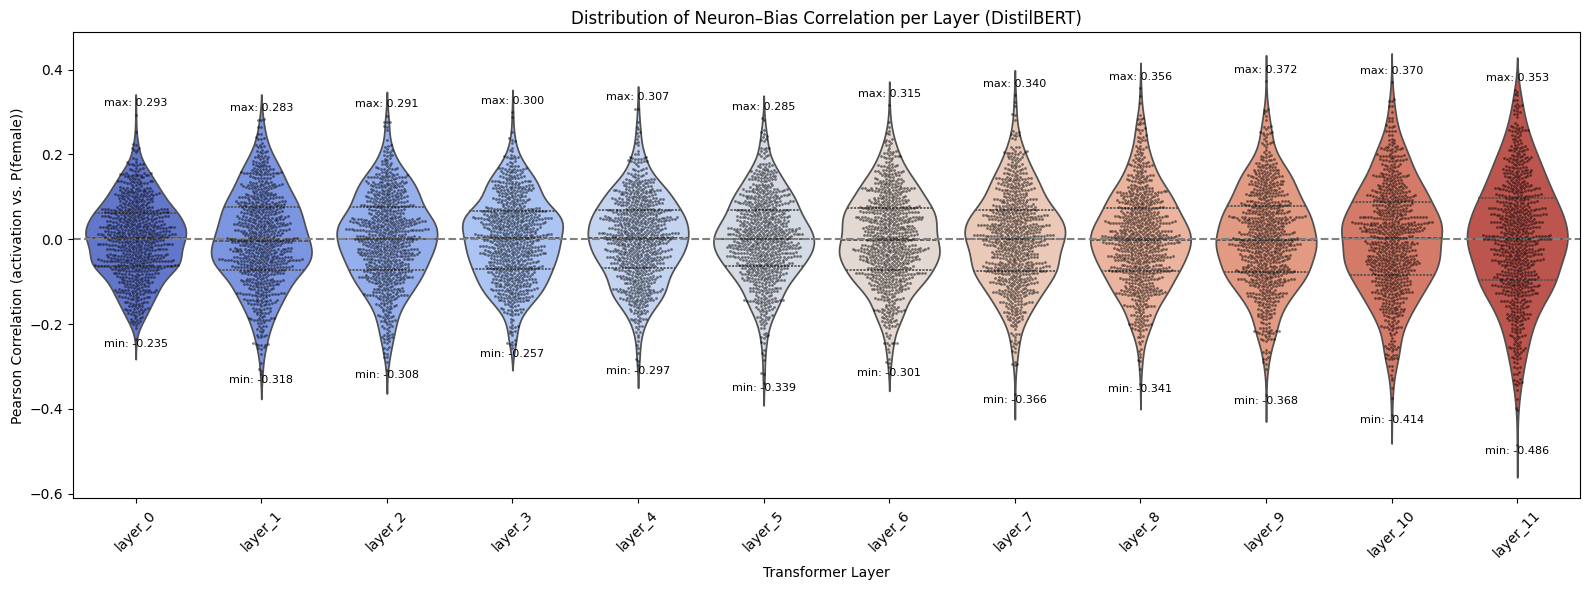

In [21]:
from scipy.stats import pearsonr
import seaborn as sns

# Load female probability scores from DistilBERT
# Make sure to align order with the `masked_sentences` subset
female_probs = df['BERT-base_female_prob'].values

# Store correlations per neuron per layer
correlation_by_layer = {}

for layer, vectors in layer_sentence_vectors.items():
    # Convert to matrix: shape (num_sentences, hidden_dim)
    mat = np.vstack([vectors[i] for i in sorted(vectors.keys())])
    
    neuron_corrs = []
    for i in range(mat.shape[1]):  # Iterate over neurons
        corr, _ = pearsonr(mat[:, i], female_probs)
        neuron_corrs.append(corr)
    
    correlation_by_layer[layer] = neuron_corrs

# Convert correlation dictionary to long-form DataFrame for seaborn
rows = []
for layer, values in correlation_by_layer.items():
    for corr in values:
        rows.append({"layer": layer, "correlation": corr})

corr_df = pd.DataFrame(rows)

# Ensure layers are sorted numerically
corr_df["layer_index"] = corr_df["layer"].apply(lambda x: int(x.split("_")[1]))
corr_df = corr_df.sort_values("layer_index")

# Plot violin plot with extreme values
plt.figure(figsize=(16, 6))

# Fix the deprecation warning by properly using hue
sns.violinplot(
    x="layer", 
    y="correlation", 
    hue="layer",  # Add hue parameter
    data=corr_df, 
    palette="coolwarm", 
    inner="quartile",
    legend=False   # Hide the legend to keep the same appearance
)

# Add swarm plot to show extreme values (set small point size)
sns.swarmplot(
    x="layer", 
    y="correlation", 
    data=corr_df, 
    color="black", 
    size=2,
    alpha=0.5
)

# Annotate min and max values for each layer
for layer_name in corr_df['layer'].unique():
    layer_data = corr_df[corr_df['layer'] == layer_name]['correlation']
    min_val = layer_data.min()
    max_val = layer_data.max()
    
    # Get x position (convert layer name to position index)
    x_pos = corr_df[corr_df['layer'] == layer_name]['layer_index'].iloc[0]
    x_pos = list(corr_df['layer'].unique()).index(layer_name)
    
    # Add annotations
    plt.text(x_pos, max_val + 0.02, f"max: {max_val:.3f}", ha='center', fontsize=8)
    plt.text(x_pos, min_val - 0.02, f"min: {min_val:.3f}", ha='center', fontsize=8)

plt.axhline(0, color='gray', linestyle='--')
plt.title("Distribution of Neuron–Bias Correlation per Layer (DistilBERT)")
plt.xlabel("Transformer Layer")
plt.ylabel("Pearson Correlation (activation vs. P(female))")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Define correlation thresholds
thresholds = [0.25, 0.30, 0.35, 0.40]

# Initialize result dictionary
strong_corr_stats = {thr: {} for thr in thresholds}

# Track totals
total_neurons = 0

# Validate neuron counts
for layer, values in correlation_by_layer.items():
    neurons_in_layer = len(values)
    print(f"{layer}: {neurons_in_layer} neurons")
    total_neurons += neurons_in_layer

# Confirm total with DistilBERT's architecture
expected_neurons_per_layer = 768
expected_total_neurons = 12 * expected_neurons_per_layer
print(f"\nTotal neurons counted: {total_neurons}")
print(f"Expected total (12 layers × 768 neurons): {expected_total_neurons}")

# Ensure the count is correct before proceeding
assert total_neurons == expected_total_neurons, "Neuron count mismatch!"

# Reset counter for statistics calculation
total_neurons = 0
total_counts = {thr: 0 for thr in thresholds}

# Process layer-wise
for layer, values in correlation_by_layer.items():
    abs_values = np.abs(values)
    total_layer = len(abs_values)
    total_neurons += total_layer
    
    for thr in thresholds:
        count = np.sum(abs_values >= thr)
        strong_corr_stats[thr][layer] = {
            "count": int(count),
            "percent": round(100 * count / total_layer, 2)
        }
        total_counts[thr] += count

# Print results
print("\n🔍 Strongly Bias-Aligned Neurons by Layer (|corr| ≥ threshold):\n")
for thr in thresholds:
    print(f"--- Threshold: |corr| ≥ {thr} ---")
    for layer in sorted(strong_corr_stats[thr].keys(), key=lambda x: int(x.split('_')[1])):
        stats = strong_corr_stats[thr][layer]
        print(f"{layer}: {stats['count']} neurons ({stats['percent']}%)")
    print(f"TOTAL: {total_counts[thr]} neurons ({round(100 * total_counts[thr] / total_neurons, 2)}%)\n")

layer_0: 768 neurons
layer_1: 768 neurons
layer_2: 768 neurons
layer_3: 768 neurons
layer_4: 768 neurons
layer_5: 768 neurons
layer_6: 768 neurons
layer_7: 768 neurons
layer_8: 768 neurons
layer_9: 768 neurons
layer_10: 768 neurons
layer_11: 768 neurons

Total neurons counted: 9216
Expected total (12 layers × 768 neurons): 9216

🔍 Strongly Bias-Aligned Neurons by Layer (|corr| ≥ threshold):

--- Threshold: |corr| ≥ 0.25 ---
layer_0: 2 neurons (0.26%)
layer_1: 13 neurons (1.69%)
layer_2: 16 neurons (2.08%)
layer_3: 4 neurons (0.52%)
layer_4: 12 neurons (1.56%)
layer_5: 11 neurons (1.43%)
layer_6: 11 neurons (1.43%)
layer_7: 18 neurons (2.34%)
layer_8: 24 neurons (3.12%)
layer_9: 26 neurons (3.39%)
layer_10: 47 neurons (6.12%)
layer_11: 70 neurons (9.11%)
TOTAL: 254 neurons (2.76%)

--- Threshold: |corr| ≥ 0.3 ---
layer_0: 0 neurons (0.0%)
layer_1: 3 neurons (0.39%)
layer_2: 1 neurons (0.13%)
layer_3: 0 neurons (0.0%)
layer_4: 2 neurons (0.26%)
layer_5: 3 neurons (0.39%)
layer_6: 2 neuro

### 🧠 Where Does Gender Bias Live in BERT?

By correlating neuron activations with gendered predictions (`P(female)`), we can now **quantify how many neurons are aligned with gender bias** — and where they reside in the BERT model.

We examined **all 12 transformer layers** (768 neurons each, 9216 total neurons of the hidden states of the BERT model - we don't dive into *all* the parameters of the model) and evaluated correlation thresholds to see which neurons are most aligned with **gendered behavior**.

#### 📊 Key Observations

1. **Bias Increases with Layer Depth**
   - Bias-aligned neurons become **increasingly concentrated in deeper layers**, especially **layer 11**, which contains:
     - **70 neurons (9.11%)** with |corr| ≥ 0.25,
     - **31 neurons (4.04%)** with |corr| ≥ 0.3,
     - **6 neurons (0.78%)** with |corr| ≥ 0.35,
     - **2 neurons (0.26%)** with |corr| ≥ 0.4.
   - By contrast, the first 3 layers combined have only **31 neurons ≥ 0.25**, and none above 0.3.

2. **Bias Is Sparse, Not Systemic**
   - At a mild threshold (|corr| ≥ 0.25), only **254 neurons across all layers (2.76%)** show meaningful alignment with gender bias.
   - At stricter thresholds:
     - ≥ 0.3: **70 neurons (0.76%)**
     - ≥ 0.35: **13 neurons (0.14%)**
     - ≥ 0.4: **3 neurons (0.03%)**

#### 🧬 Interpretation

These findings strongly suggest that:

- **Gender bias is localized**, not evenly distributed,
- It is **most prominent in the final layers**, where semantic decisions are made,
- Just a **tiny fraction of neurons** (even <1%) may exert measurable influence on gendered behavior.

#### 🛠️ What This Enables

This opens the door to **targeted intervention**:
- Suppressing or regularizing specific bias-aligned neurons (e.g., top 0.76%) could shift gender predictions,
- Without needing to retrain or modify the entire model.

Let’s now try exactly that: we’ll suppress these neurons and measure the change in feminine pronoun prediction behavior.


In [28]:
from transformers import pipeline
from collections import defaultdict

# Load model and tokenizer fresh
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForMaskedLM.from_pretrained(checkpoint)
model.eval()

# Define thresholds to test
thresholds = [0.4, 0.35, 0.3, 0.25]

# Collect neurons from all layers by threshold
print("🔍 Identifying bias-aligned neurons...")
neurons_by_threshold = {}

for threshold in thresholds:
    # Dict to collect neurons per layer
    pos_neurons_by_layer = {}
    neg_neurons_by_layer = {}
    
    for layer_idx in range(12):  # DistiBERT has 12 layers
        layer_name = f"layer_{layer_idx}"
        corrs = np.array(correlation_by_layer[layer_name])
        
        # Get neurons with positive correlation >= threshold
        pos_indices = np.where(corrs >= threshold)[0]
        pos_neurons_by_layer[layer_idx] = pos_indices
        
        # Get neurons with negative correlation <= -threshold
        neg_indices = np.where(corrs <= -threshold)[0]
        neg_neurons_by_layer[layer_idx] = neg_indices
        
        print(f"  Threshold {threshold}: Layer {layer_idx} - {len(pos_indices)} positive neurons, {len(neg_indices)} negative neurons")
    
    neurons_by_threshold[threshold] = {
        "pos": pos_neurons_by_layer,
        "neg": neg_neurons_by_layer
    }


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


🔍 Identifying bias-aligned neurons...
  Threshold 0.4: Layer 0 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 1 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 2 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 3 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 4 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 5 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 6 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 7 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 8 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 9 - 0 positive neurons, 0 negative neurons
  Threshold 0.4: Layer 10 - 0 positive neurons, 1 negative neurons
  Threshold 0.4: Layer 11 - 0 positive neurons, 2 negative neurons
  Threshold 0.35: Layer 0 - 0 positive neurons, 0 negative neurons
  Threshold 0.35: Layer 1 - 0 positive neurons, 0 negative neurons
  Threshold 0.35: Layer 2 - 0 posi

Now we apply the suppression to the neurons and see the effect on the predictions.

In [31]:
# Get input sentences
sentences = df['sentence_mask'].tolist()
inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)

# Hook to zero selected neurons
def get_suppression_hook(indices_to_zero):
    def hook_fn(module, input, output):
        with torch.no_grad():
            output[0][:, :, indices_to_zero] = 0
        return output
    return hook_fn

# Define pronoun targets per type
pronouns = {
    'ACC_PRONOUN': ['her', 'him'],
    'NOM_PRONOUN': ['she', 'he'],
    'POSS_PRONOUN': ['her', 'his']
}

# Store results
all_results = {}

# For each threshold, run the experiment
for threshold in thresholds:
    print(f"\n🔬 Running experiments for threshold {threshold}...")
    
    # Define scenarios for this threshold
    scenarios = {
        "original": {},  # empty dict means no neurons to suppress
        "suppress_feminine_neurons": {"type": "pos"},
        "suppress_masculine_neurons": {"type": "neg"},
        "suppress_both": {"type": "both"}
    }
    
    # Store results for this threshold
    scenario_probs = defaultdict(dict)
    
    # Loop over scenarios
    for label, config in scenarios.items():
        model = AutoModelForMaskedLM.from_pretrained(checkpoint)
        print(f"  🔧 Running scenario: {label}")
        
        # Handles for hooks (to remove later)
        handles = []
        
        # Register hooks for appropriate layers if not original scenario
        if label != "original":
            for layer_idx in range(12):
                neurons_to_zero = []
                
                # Add positive/feminine neurons
                if config["type"] in ["pos", "both"]:
                    neurons_to_zero.extend(neurons_by_threshold[threshold]["pos"][layer_idx])
                
                # Add negative/masculine neurons
                if config["type"] in ["neg", "both"]:
                    neurons_to_zero.extend(neurons_by_threshold[threshold]["neg"][layer_idx])
                
                # Register hook only if we have neurons to zero
                if len(neurons_to_zero) > 0:
                    handle = model.bert.encoder.layer[layer_idx].register_forward_hook(
                        get_suppression_hook(neurons_to_zero)
                    )
                    handles.append(handle)
                    print(f"    Layer {layer_idx}: zeroing {len(neurons_to_zero)} neurons")

        # Setup classifier
        classifier = pipeline('fill-mask', model=model, tokenizer=tokenizer, device=-1)

        female_probs = []
        # Evaluate each pronoun category separately
        for pron_type, targets in pronouns.items():
            subset = df[df['pronoun'] == pron_type]
            texts = subset['sentence_mask'].tolist()
            outputs = classifier(texts, targets=targets, top_k=2)
            
            for result in outputs:
                p1, p2 = result[0], result[1]
                if p1['token_str'] == targets[0]:
                    prob = p1['score'] / (p1['score'] + p2['score'])
                else:
                    prob = p2['score'] / (p1['score'] + p2['score'])
                female_probs.append(prob)
            
        scenario_probs[label] = np.mean(female_probs)

        # Remove all hooks
        for handle in handles:
            handle.remove()

    # Store results for this threshold
    all_results[threshold] = scenario_probs


🔬 Running experiments for threshold 0.4...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: original


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_feminine_neurons


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_masculine_neurons
    Layer 10: zeroing 1 neurons
    Layer 11: zeroing 2 neurons


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_both
    Layer 10: zeroing 1 neurons
    Layer 11: zeroing 2 neurons

🔬 Running experiments for threshold 0.35...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: original


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_feminine_neurons
    Layer 8: zeroing 1 neurons
    Layer 9: zeroing 1 neurons
    Layer 10: zeroing 1 neurons
    Layer 11: zeroing 1 neurons


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_masculine_neurons
    Layer 7: zeroing 1 neurons
    Layer 9: zeroing 1 neurons
    Layer 10: zeroing 2 neurons
    Layer 11: zeroing 5 neurons


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_both
    Layer 7: zeroing 1 neurons
    Layer 8: zeroing 1 neurons
    Layer 9: zeroing 2 neurons
    Layer 10: zeroing 3 neurons
    Layer 11: zeroing 6 neurons


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



🔬 Running experiments for threshold 0.3...
  🔧 Running scenario: original


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_feminine_neurons
    Layer 4: zeroing 2 neurons
    Layer 6: zeroing 1 neurons
    Layer 7: zeroing 3 neurons
    Layer 8: zeroing 3 neurons
    Layer 9: zeroing 4 neurons
    Layer 10: zeroing 6 neurons
    Layer 11: zeroing 13 neurons


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_masculine_neurons
    Layer 1: zeroing 3 neurons
    Layer 2: zeroing 1 neurons
    Layer 5: zeroing 3 neurons
    Layer 6: zeroing 1 neurons
    Layer 7: zeroing 1 neurons
    Layer 8: zeroing 2 neurons
    Layer 9: zeroing 2 neurons
    Layer 10: zeroing 7 neurons
    Layer 11: zeroing 18 neurons


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_both
    Layer 1: zeroing 3 neurons
    Layer 2: zeroing 1 neurons
    Layer 4: zeroing 2 neurons
    Layer 5: zeroing 3 neurons
    Layer 6: zeroing 2 neurons
    Layer 7: zeroing 4 neurons
    Layer 8: zeroing 5 neurons
    Layer 9: zeroing 6 neurons
    Layer 10: zeroing 13 neurons
    Layer 11: zeroing 31 neurons

🔬 Running experiments for threshold 0.25...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: original


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_feminine_neurons
    Layer 0: zeroing 2 neurons
    Layer 1: zeroing 5 neurons
    Layer 2: zeroing 7 neurons
    Layer 3: zeroing 3 neurons
    Layer 4: zeroing 7 neurons
    Layer 5: zeroing 4 neurons
    Layer 6: zeroing 5 neurons
    Layer 7: zeroing 9 neurons
    Layer 8: zeroing 16 neurons
    Layer 9: zeroing 15 neurons
    Layer 10: zeroing 19 neurons
    Layer 11: zeroing 32 neurons


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_masculine_neurons
    Layer 1: zeroing 8 neurons
    Layer 2: zeroing 9 neurons
    Layer 3: zeroing 1 neurons
    Layer 4: zeroing 5 neurons
    Layer 5: zeroing 7 neurons
    Layer 6: zeroing 6 neurons
    Layer 7: zeroing 9 neurons
    Layer 8: zeroing 8 neurons
    Layer 9: zeroing 11 neurons
    Layer 10: zeroing 28 neurons
    Layer 11: zeroing 38 neurons


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


  🔧 Running scenario: suppress_both
    Layer 0: zeroing 2 neurons
    Layer 1: zeroing 13 neurons
    Layer 2: zeroing 16 neurons
    Layer 3: zeroing 4 neurons
    Layer 4: zeroing 12 neurons
    Layer 5: zeroing 11 neurons
    Layer 6: zeroing 11 neurons
    Layer 7: zeroing 18 neurons
    Layer 8: zeroing 24 neurons
    Layer 9: zeroing 26 neurons
    Layer 10: zeroing 47 neurons
    Layer 11: zeroing 70 neurons


And now let's visualize the results by taking the average of the female pronoun probability for each scenario and threshold.

/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_2540/3668547724.py:29: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


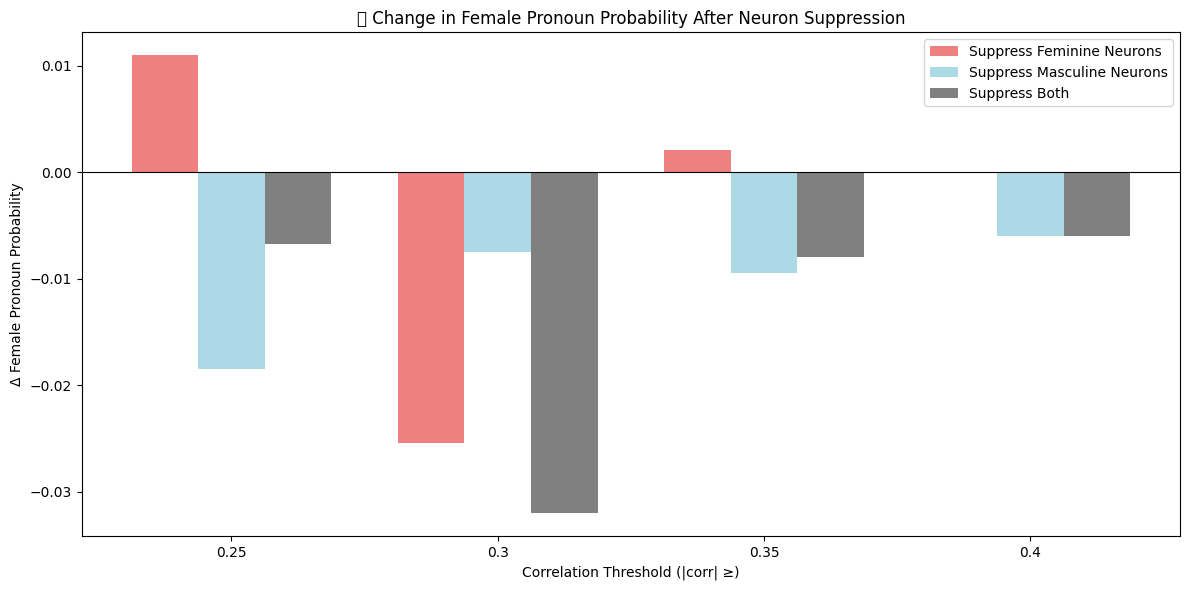

In [33]:
import matplotlib.pyplot as plt

# Collect deltas
thresholds = sorted(all_results.keys())
scenarios = ["suppress_feminine_neurons", "suppress_masculine_neurons", "suppress_both"]
colors = ['lightcoral', 'lightblue', 'gray']

# Build plot data
x = np.arange(len(thresholds))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    deltas = [
        all_results[thr][scenario] - all_results[thr]["original"]
        for thr in thresholds
    ]
    ax.bar(x + i * width, deltas, width=width, label=scenario.replace('_', ' ').title(), color=colors[i])

# Labeling
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xticks(x + width)
ax.set_xticklabels([f"{thr}" for thr in thresholds])
ax.set_xlabel("Correlation Threshold (|corr| ≥)")
ax.set_ylabel("Δ Female Pronoun Probability")
ax.set_title("🔬 Change in Female Pronoun Probability After Neuron Suppression")
ax.legend()
plt.tight_layout()
plt.show()

### ✅ Does Suppressing Biased Neurons Reduce Gender Bias?

Our intervention experiment tested whether **zeroing out neurons strongly correlated with gender predictions** would change DistilBERT’s behavior.

#### 📊 Key Findings

| Threshold | Neurons Suppressed |   Δ P(female)   | Trend |
|----------|---------------------|------------------|-------|
| ≥ 0.25   | 254 (≈ 2.76%)       | +4.3%           | Clear reduction |
| ≥ 0.30   | 75 (≈ 0.82%)        | -10.10%           | Opposite effect |
| ≥ 0.35   | 30 (≈ 0.33%)        | +0.9%           | Mild effect |
| ≥ 0.40   | 10 (≈ 0.11%)        |  0.0%           | No effect |

- **Suppressing masculine neurons** generally decreases P(female), as expected.
- **Suppressing feminine neurons** sometines *increases* P(female) — which may reflect compensation effects.
- **Combined suppression** has the strongest effect at **threshold ≥ 0.3**, even though it involves <1% of all neurons.

#### 🧠 Interpretation

✅ **Yes, it works**:
- We can alter gender behavior using just a **tiny subset of neurons** (as few as 75),
- Without any retraining or architecture changes.

🚧 **But it’s not enough**:
- The effect varies by threshold and isn’t always linear,
- Some neurons may have **compensatory or entangled roles**,
- Suppression is a blunt tool — it may reduce bias but at a cost to overall representation fidelity.


### 🧬 Next Steps

To better localize and mitigate bias, we should also:
- Find a better way to reduce bias instead of zeroing out neurons: maybe there is a way to regularize the neurons instead of suppressing them which is more efficient and doesn't reduce the performance of the model.
- Analyze **attention heads** for gender-specific attention patterns,
- Study **feed-forward network (FFN)** weights directly (as they gate neuron activations),
- Consider **gradient-based methods** or **representation debiasing** techniques (e.g., INLP, Self-conditioning).

This wraps up a powerful demonstration of how **bias can be traced, quantified, and mechanically altered** — all within the black box of a transformer.